# VS Ensemble Dockig CDK2
## Análisis de datos exploratorio

- 111 ligandos
    - 27 Activos
- 402 Conformaciones de la porteína CDK2
    - Conformaciones experimentales
- 3 progrmas de acoplamiento molecular

### Contenido:
- Pendiente agregar las secciones

In [1]:
import pandas as pd 
import numpy as np 

### Carga de los datos

In [3]:
# Directorio
data_dir = './data'


In [2]:
# Carga de los dataFrames
# Autodock 4. LE (lowest energy), LC (largest Cluster)
df_ad4_results_LE = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_AD4_LE.csv', index_col=0)
df_ad4_results_LC = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_AD4_LC.csv', index_col=0)
# Autodock Vina
df_vina_results = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_VINA.csv', index_col=0)
# Vinardo scoring
df_vinardo_results = pd.read_csv(F'{data_dir}/vs_docking_crys_ensemble_VINARDO.csv', index_col=0)

### Datos de Vina y Vinardo
<div class="p-3 mb-2 bg-danger text-dark">Conformaiones minimizadas de las 402 estructuras.</div>

In [4]:
# Autodock Vina
df_vina_results_MIN = pd.read_csv(F'{data_dir}/vs_docking_CSAR_vs_402_MIN_vina.csv', index_col=0)
# Vinardo scoring
df_vinardo_results_MIN = pd.read_csv(F'{data_dir}/vs_docking_CSAR_vs_402_MIN_vinardo.csv', index_col=0)

Todas los dataFrames poseen 111 filas (111 ligandos) y 403 columnas, correspondientes a la etiqueta de actividad/inactividad, y a las 402 conformaciones. 

### Datos CDK2 de CSAR
Las etiquetas de actividad y la información sobre los 111 ligandos se encuentran en el siguiente [enlace](https://drugdesigndata.org/about/datasets/220).

### Comenzamos el análisis de los datos

In [11]:
# Identificamos a los ligandos que son activos
activos =  df_vina_results.ActiveInactive == "Active"

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Definimos una función para graficar boxplots
def plot_boxplot_dock_results(df, titulo=''):
    '''Función para graficar boxplots de los resultados de acoplamiento molecular'''
    num_ligs, num_conf = df.iloc[:, 2:-1].shape
    fig, ax = plt.subplots(figsize =(20, 5))
    sns.set_style("white"); sns.set_context("paper")
    ax.axvspan(0, 3, color=sns.xkcd_rgb['grey'], alpha=0.3)
    ax.axvspan(5, 16, color=sns.xkcd_rgb['grey'], alpha=0.3)
    ax.axvspan(101, 110, color=sns.xkcd_rgb['grey'], alpha=0.3)
    sns.boxplot(ax = ax,  data = df.iloc[:, 2:-1].T )
    plt.title(F"{titulo}: Boxplots - {num_ligs} ligandos - {num_conf} conformaciones", size = 20)
    plt.xticks(rotation=90, size=11)
    ax.set_ylabel(F'{titulo} Score (kcal/mol)', fontsize=18)
    ax.set_xlabel('Ligandos CSAR', fontsize=18)
    plt.show()

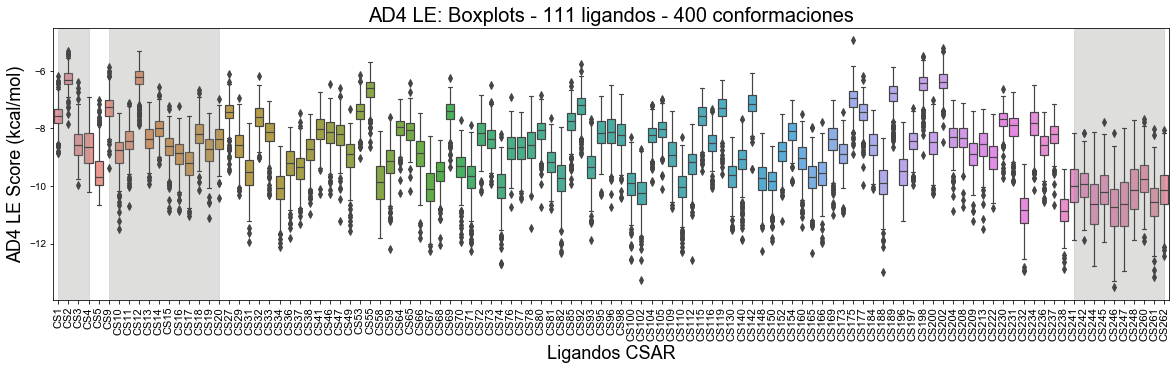

In [6]:
plot_boxplot_dock_results(df_ad4_results_LE, titulo="AD4 LE")

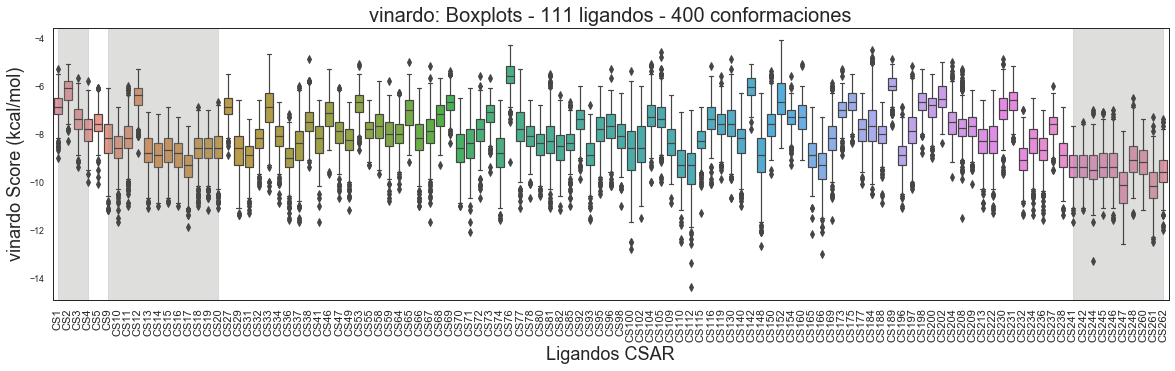

In [7]:
plot_boxplot_dock_results(df_vinardo_results, titulo="vinardo")

En cada gráfica, se muestran los 111 ligandos y sus scores para cada una de las 402 conformaciones de la proteína.

# Curvas ROC

In [5]:
# Librerías para calcular las ROC y el AUC
from sklearn.metrics import roc_curve, roc_auc_score

Etiquetas de los ligandos, **1 = Activo**.

In [6]:
true_values = np.array(df_vina_results.ActiveInactive == "Active", dtype=int)
print(true_values)

[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


Calculamos el **AUC** tomando en cuenta los *rankings* de cada programa de *docking* a partir del promedio de los ranking por conformación.

In [7]:
sc_promedio_vrd = np.array(df_vinardo_results.mean(axis=1))
sc_promedio_vina = np.array(df_vina_results.mean(axis=1))
sc_promedio_ad4_LE = np.array(df_ad4_results_LE.mean(axis=1))
sc_promedio_ad4_LC = np.array(df_ad4_results_LC.mean(axis=1))

**Curvas ROC:**

In [8]:
print('AUC del valor PROMEDIO (402 estructuras):')
print("AD4 LE:", 
        roc_auc_score( y_true = true_values, y_score = (- sc_promedio_ad4_LE)) )        
print("AD4 LC:", 
        roc_auc_score( y_true = true_values, y_score = (- sc_promedio_ad4_LC)) )
print("Vina 16x:", 
        roc_auc_score( y_true = true_values, y_score = (- sc_promedio_vina)) )
print("Vinardo 16x:", 
        roc_auc_score( y_true = true_values, y_score = (- sc_promedio_vrd)) )   

AUC del valor PROMEDIO (402 estructuras):
AD4 LE: 0.5941176470588236
AD4 LC: 0.6900452488687783
Vina 16x: 0.5524886877828055
Vinardo 16x: 0.7610859728506787


**Gráficas de las ROC.**

In [12]:
# Establecemos los parámetros para graficar
import pylab
pylab.rcParams['figure.figsize'] = (7, 7)
sns.set( context = 'talk', style = 'white', palette = "Set2")

def add_plot_roc(predicted_values, true_values, label = ''):
    inverted_input = np.negative(predicted_values)
    fpr, tpr, thresholds = roc_curve(true_values, inverted_input)
    auc = roc_auc_score( y_true = true_values, y_score = inverted_input)
    plt.plot(fpr, tpr, label= label + ' AUC = %0.2f' % auc, lw = 4)

def plot_roc(predicted_values, true_values, label = '', titulo = "ROC curve"):
    sns.color_palette("Paired")
    add_plot_roc(predicted_values, true_values, label)
    plt.legend()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("FPR (1 - specificity)")
    plt.ylabel("TPR (sensitivity)")
    plt.grid(linestyle='--', linewidth='0.8')
    plt.title(titulo)
    plt.show()

## Probando *scoring consensus* más comunes

**Fuente:** _[Exponential consensus ranking improves the outcome in docking and receptor ensemble docking](https://www.nature.com/articles/s41598-019-41594-3)_

### ROC con valores promedio (Rank-by-number)
Gráfica **ROC** con valores promedio.
> El score final de cada ligando ($R_bN_i$) corresponde al *score* promedio de cada ligando $i$ en todas las $n$ conformaciones:

> $R_bN_i = \frac{1}{n}\sum_js_i^j,$

donde $n$ es el número de conformaciones, y $s_i^j$ es el score de la molécula $i$ con la conformación $j$.

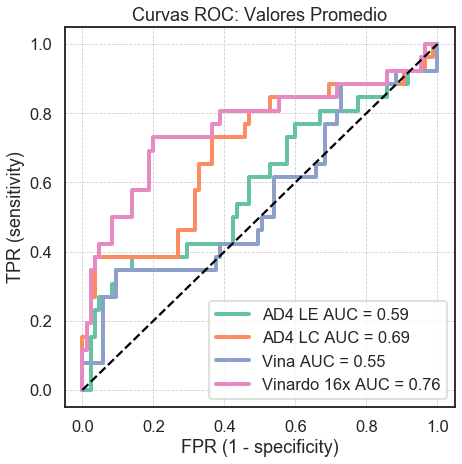

In [13]:
add_plot_roc(sc_promedio_ad4_LE, true_values, "AD4 LE")
add_plot_roc(sc_promedio_ad4_LC, true_values, "AD4 LC")
add_plot_roc(sc_promedio_vina, true_values, "Vina")
#add_plot_roc(sc_promedio_vrd_8x, true_values, "Vinardo 8x")
plot_roc(sc_promedio_vrd, true_values, "Vinardo 16x", "Curvas ROC: Valores Promedio")

### ROC con mejores *scores* de cada método
Gráficas **ROC**, si para el **ranking** final extrajeramos el mejor score de cada ligando, es decir, de los $n$ scores obtenidos para una molécula $i$, nos quedamos con el mínimo:

> $best\ score_i = min(s_i),$

donde $s_i$ es un vector de $n$ scores donde cada posición $j$ corresponde al score entre la molécula $i$ y la conformación $j$.

In [14]:
# Scorings mínimos (mejores) de cada ligando
sc_minimo_vrd = np.array(df_vinardo_results.min(axis=1))
sc_minimo_vina = np.array(df_vina_results.min(axis=1))
sc_minimo_ad4_LE = np.array(df_ad4_results_LE.min(axis=1))
sc_minimo_ad4_LC = np.array(df_ad4_results_LC.min(axis=1))

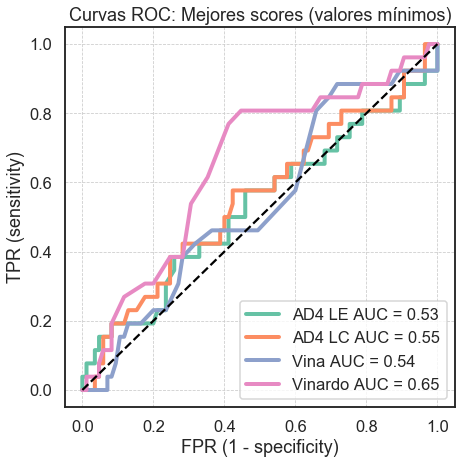

In [15]:
add_plot_roc(sc_minimo_ad4_LE, true_values, "AD4 LE")
add_plot_roc(sc_minimo_ad4_LC, true_values, "AD4 LC")
add_plot_roc(sc_minimo_vina, true_values, "Vina")
plot_roc(sc_minimo_vrd, true_values, "Vinardo", "Curvas ROC: Mejores scores (valores mínimos)")

### ROC *rank-by-rank*
Gráfica **ROC** con valores de rango por rango.
> Pra cada conformación $j$ las $m$ moléculas son rankeadas (ordenadas) y a la molécula con el mejor scoring se le asigna el valor de 1 mientras que a la molécula en la posición $m$ se le asigna el valor $m$. Posteriormente se obtiene la media de los valores d erango de cada molécula en las $n$ conformaciones.

> $R_bR_i = \frac{1}{n}\sum_jr^i_j,$

donde $n$ es el número de conformaciones, y $r^i_j$ es la posición de la molécula $i$ en el rango de la conformación $j$.

In [16]:
def get_rank_by_rank(df):
    df_ranks = df.rank() # Obtenemos los rankings de cada ligando
    # Para cada ligando i se obtiene la media de su valor en las n conformaciones
    df_rank_by_rank = np.array(df_ranks.mean(axis = 1))
    return(df_rank_by_rank)

In [17]:
r_by_r_vrd = get_rank_by_rank(df_vinardo_results.drop(['ActiveInactive'], axis = 1))
r_by_r_vina = get_rank_by_rank(df_vina_results.drop(['ActiveInactive'], axis = 1))
r_by_r_ad4_LE = get_rank_by_rank(df_ad4_results_LE.drop(['ActiveInactive'], axis = 1))
r_by_r_ad4_LC = get_rank_by_rank(df_ad4_results_LC.drop(['ActiveInactive'], axis = 1))

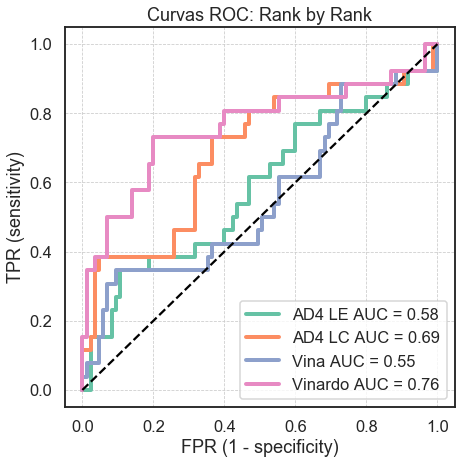

In [18]:
add_plot_roc(r_by_r_ad4_LE, true_values, "AD4 LE")
add_plot_roc(r_by_r_ad4_LC, true_values, "AD4 LC")
add_plot_roc(r_by_r_vina, true_values, "Vina")
plot_roc(r_by_r_vrd, true_values, "Vinardo", "Curvas ROC: Rank by Rank")

### ROC z-score
> Estandarización por conformación (columna). El *score* $s_i^j$ de la molécula $i$ en la conformación $j$ es estandarizado. Es decir, usamos la media de los $m$ scores en la conformación j ($\mu^j$) y su desviación estándar ($\sigma^j$). Posteriormente se obtiene la media de todos los scores estandarizados de la molécula $i$:

> $z-score_i = \frac{1}{n}\sum_j\frac{s_i^j - \mu^j}{\sigma^j}$

In [19]:
from sklearn.preprocessing import StandardScaler

def get_zscore(df):
    means = df.mean(axis=0) # media por columna
    stds = df.std(axis=0) # std por columna
    # df_centered_values = (df - means)/stds
    df_centered_values = StandardScaler().fit_transform(df)
    z_score =  df_centered_values.mean(axis=1)
    return(z_score)

In [20]:
z_score_vrd = get_zscore(df_vinardo_results.drop(['ActiveInactive'], axis = 1))
z_score_vina = get_zscore(df_vina_results.drop(['ActiveInactive'], axis = 1))
z_score_ad4_LE = get_zscore(df_ad4_results_LE.drop(['ActiveInactive'], axis = 1))
z_score_ad4_LC = get_zscore(df_ad4_results_LC.drop(['ActiveInactive'], axis = 1))

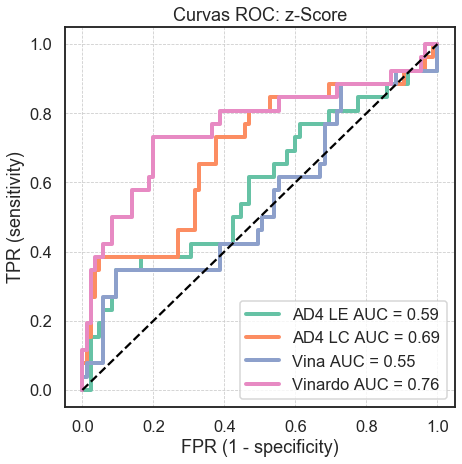

In [21]:
add_plot_roc(z_score_ad4_LE, true_values, "AD4 LE")
add_plot_roc(z_score_ad4_LC, true_values, "AD4 LC")
add_plot_roc(z_score_vina, true_values, "Vina")
plot_roc(z_score_vrd, true_values, "Vinardo", "Curvas ROC: z-Score")

## ROC con *ranking* de los scores de una sola conformación
Curva ROC a partir del *ranking* de una conformación dada: "**1aq1**"

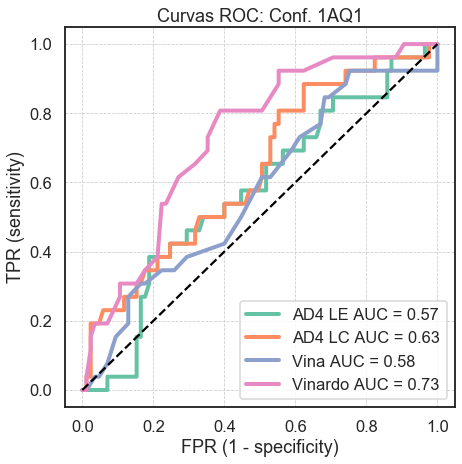

In [22]:
# Curva ROC dada una conformación
pdb_id = "1aq1"
add_plot_roc(df_ad4_results_LE[ pdb_id ], true_values, "AD4 LE")
add_plot_roc(df_ad4_results_LC[ pdb_id ], true_values, "AD4 LC")
add_plot_roc(df_vina_results[ pdb_id ], true_values, "Vina")
plot_roc(df_vinardo_results[ pdb_id ], true_values, "Vinardo", F"Curvas ROC: Conf. {pdb_id.upper()}")

## Calculamos el AUC para todas las conformaciones
Se realiza el cálculo del AUC de todas las conformaciones tomando en cuenta los 4 DataFrames de *scores* disponibles.

In [16]:
# Calculo del AUC por conformaión
# carga del dataFrame con la información general de las estructuras cristalográficas
df_cdk2_labels = pd.read_json(F"{data_dir}/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS.json")

**Cálculo de AUC para cada conformación.**

In [17]:
df_cdk2_labels["AUC_vrd_16x"] = 0.0
df_cdk2_labels["AUC_vina_16x"] = 0.0
df_cdk2_labels["AUC_ad4_LC"] = 0.0
for pdb in df_cdk2_labels.index:
    # Vinardo 16x
    roc_vrd = roc_auc_score(np.array(true_values), - df_vinardo_results[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_vrd_16x"] = roc_vrd
    # Vina 16x
    roc_vina = roc_auc_score(np.array(true_values), - df_vina_results[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_vina_16x"] = roc_vina
    # Autodock 4: LE
    roc_ad4_LE = roc_auc_score(np.array(true_values), - df_ad4_results_LE[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_ad4_LE"] = roc_ad4_LE
    # Autodock 4: LC
    roc_ad4_LC = roc_auc_score(np.array(true_values), - df_ad4_results_LC[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_ad4_LC"] = roc_ad4_LC

### Guardamos el dataFrame

<div class="p-3 mb-2 bg-warning text-dark">Descomentar para guardar.</div>

In [25]:
# Guardamos el dataframe
# df_cdk2_labels.to_json(F"{data_dir}/TABLA_MTDATA_CDK2_402_crys_LIGS_INFO_LABELS_AUC_docking.json")

## Conformaciones minimizadas

In [18]:
df_cdk2_labels["AUC_vrd_402MIN"] = 0.0
df_cdk2_labels["AUC_vina_402MIN"] = 0.0
for pdb in df_cdk2_labels.index:
    # Vinardo 16x, con conformaciones de proteína minimizadas
    roc_vrd = roc_auc_score(np.array(true_values), - df_vinardo_results_MIN[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_vrd_402MIN"] = roc_vrd
    # Vina 16x, con conformaciones de proteina minimizadas
    roc_vina = roc_auc_score(np.array(true_values), - df_vina_results_MIN[ pdb ])
    df_cdk2_labels.at[ pdb, "AUC_vina_402MIN"] = roc_vina

## Tabla Final

In [22]:
df_cdk2_labels.iloc[:, -8:]

,Inhib_mass,Labels_conf,AUC_vrd_16x,AUC_vina_16x,AUC_ad4_LC,AUC_ad4_LE,AUC_vrd_402MIN,AUC_vina_402MIN
1aq1,440.0,inact_b,0.730317,0.575339,0.634163,0.572172,0.726471,0.565385
1b38,398.0,inact_a,0.677828,0.546154,0.571946,0.483032,0.656109,0.535520
1b39,398.0,inact_a,0.764706,0.580543,0.670814,0.607919,0.668326,0.483258
1buh,,inact_a,0.708145,0.535294,0.613348,0.544344,0.781900,0.638009
1ckp,214.0,inact_a,0.766968,0.571493,0.764932,0.715385,0.709276,0.546833
...,...,...,...,...,...,...,...,...
6q4g,258.0,inact_a,0.629638,0.547511,0.539593,0.483484,0.585747,0.508597
6q4h,274.0,inact_a,0.534389,0.467873,0.496606,0.467195,0.538914,0.480543
6q4i,234.0,inact_a,0.644118,0.559276,0.580769,0.486652,0.616063,0.516063
6q4j,218.0,inact_a,0.557692,0.502262,0.538235,0.478733,0.516968,0.525113


## Conformaciones con mejor AUC por Método de score
### ROC con *ranking* de la MEJOR conformación en Vinardo a 16x
Curva ROC a partir del *ranking* de la mejor conformación con Vinardo (conformación con mejor AUC de vinardo).

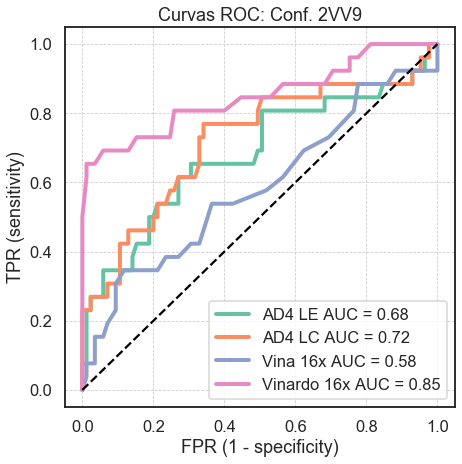

In [26]:
# ROC de la mejor conformación de vinardo
pdb_id = df_cdk2_labels[["AUC_vrd_16x"]].idxmax()[0]

add_plot_roc(df_ad4_results_LE[ pdb_id ], true_values, "AD4 LE")
add_plot_roc(df_ad4_results_LC[ pdb_id ], true_values, "AD4 LC")
add_plot_roc(df_vina_results[ pdb_id ], true_values, "Vina 16x")
plot_roc(df_vinardo_results[ pdb_id ], true_values, "Vinardo 16x", F"Curvas ROC: Conf. {pdb_id.upper()}")

### ROC con *ranking* de la MEJOR conformación en Vinardo a 8x

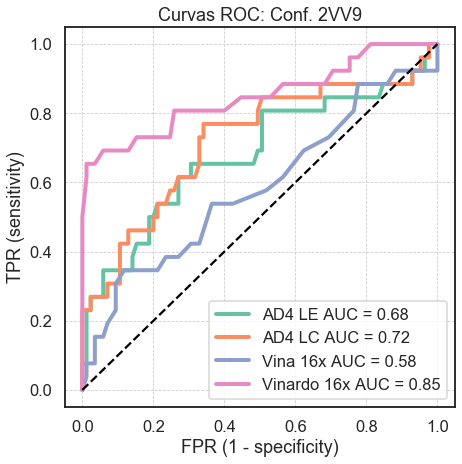

In [27]:
# ROC de la mejor conformación de vinardo a 8x
pdb_id = df_cdk2_labels[["AUC_vrd_16x"]].idxmax()[0]

add_plot_roc(df_ad4_results_LE[ pdb_id ], true_values, "AD4 LE")
add_plot_roc(df_ad4_results_LC[ pdb_id ], true_values, "AD4 LC")
add_plot_roc(df_vina_results[ pdb_id ], true_values, "Vina 16x")
plot_roc(df_vinardo_results[ pdb_id ], true_values, "Vinardo 16x", F"Curvas ROC: Conf. {pdb_id.upper()}")

### ROC con ranking de la MEJOR conformación en Vina a 16x

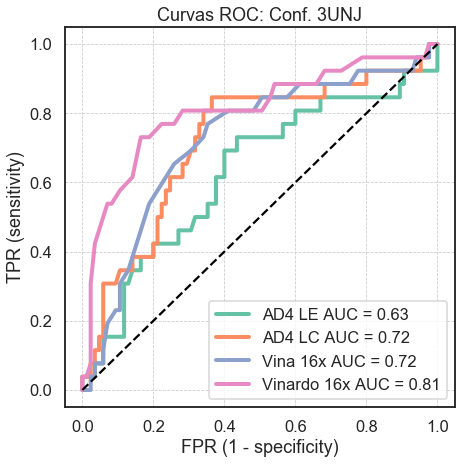

In [28]:
# ROC de la mejor conformación de vina a 16x
pdb_id = df_cdk2_labels[["AUC_vina_16x"]].idxmax()[0]

add_plot_roc(df_ad4_results_LE[ pdb_id ], true_values, "AD4 LE")
add_plot_roc(df_ad4_results_LC[ pdb_id ], true_values, "AD4 LC")
add_plot_roc(df_vina_results[ pdb_id ], true_values, "Vina 16x")
plot_roc(df_vinardo_results[ pdb_id ], true_values, "Vinardo 16x", F"Curvas ROC: Conf. {pdb_id.upper()}")

### ROC con ranking de la MEJOR conformación en AD4 LC

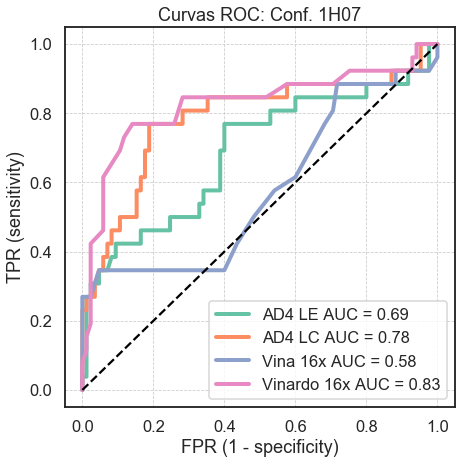

In [29]:
# ROC de la mejor conformación de ad4 LC
pdb_id = df_cdk2_labels[["AUC_ad4_LC"]].idxmax()[0]

add_plot_roc(df_ad4_results_LE[ pdb_id ], true_values, "AD4 LE")
add_plot_roc(df_ad4_results_LC[ pdb_id ], true_values, "AD4 LC")
add_plot_roc(df_vina_results[ pdb_id ], true_values, "Vina 16x")
plot_roc(df_vinardo_results[ pdb_id ], true_values, "Vinardo 16x", F"Curvas ROC: Conf. {pdb_id.upper()}")

### ROC con ranking de la MEJOR conformación en AD4 LE

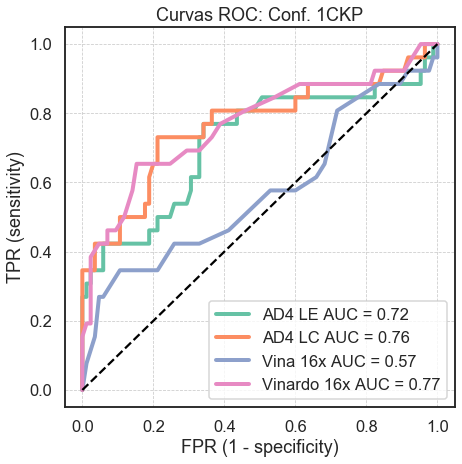

In [30]:
# ROC de la mejor conformación de ad4 LC
pdb_id = df_cdk2_labels[["AUC_ad4_LE"]].idxmax()[0]

add_plot_roc(df_ad4_results_LE[ pdb_id ], true_values, "AD4 LE")
add_plot_roc(df_ad4_results_LC[ pdb_id ], true_values, "AD4 LC")
add_plot_roc(df_vina_results[ pdb_id ], true_values, "Vina 16x")
plot_roc(df_vinardo_results[ pdb_id ], true_values, "Vinardo 16x", F"Curvas ROC: Conf. {pdb_id.upper()}")

## Distribución de AUC por programa de *docking*
### *Violin plots*

In [31]:
# Seleccionamos las columnas que poseen los scores para cada método usado
df_auc_scores = df_cdk2_labels[['AUC_ad4_LE', 'AUC_ad4_LC', 
                'AUC_vina_16x', 'AUC_vrd_16x']]

## Valor de AUC por scoring vs conformación
**Se comparar únicamente los resultados en la evaluación con el set de CSAR**

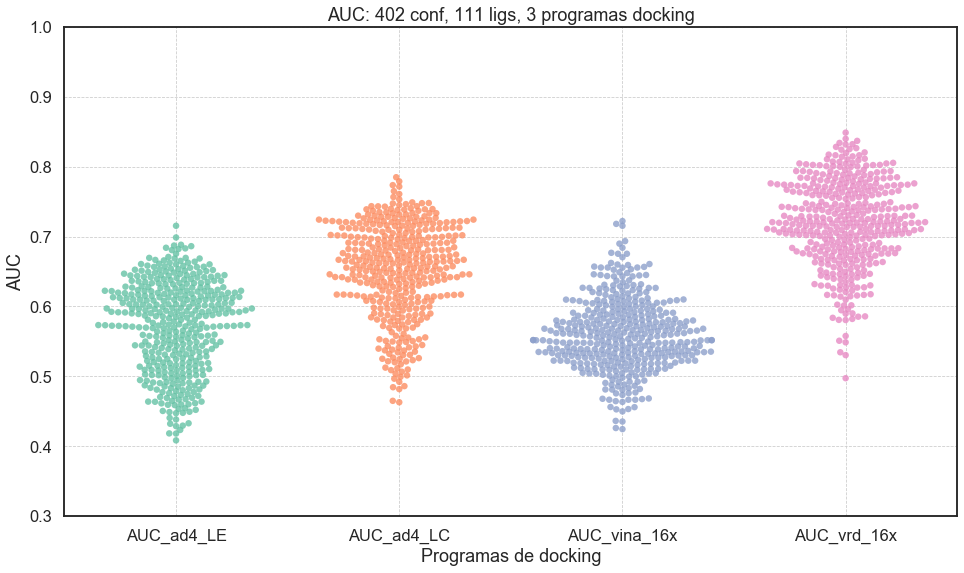

In [32]:
fig, axes = plt.subplots()

cmp = sns.set_palette(['#fa9a58',  '#cf384d', '#93d067',  '#3498db'])
data = df_auc_scores
data = data.melt()
data['Conf Labels'] = np.tile(df_cdk2_labels.Labels_conf, 4)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
               palette=  'Set2', s = 6.5)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

## Comparación con conformaciones minimizadas
### Vina y Vinardo

In [23]:
# Seleccionamos las columnas que poseen los scores para cada método usado
df_auc_scores_CRYS_vs_MIN = df_cdk2_labels[['AUC_ad4_LE', 'AUC_ad4_LC', 
                                            'AUC_vina_16x', 'AUC_vrd_16x',
                                            'AUC_vina_402MIN', 'AUC_vrd_402MIN']]

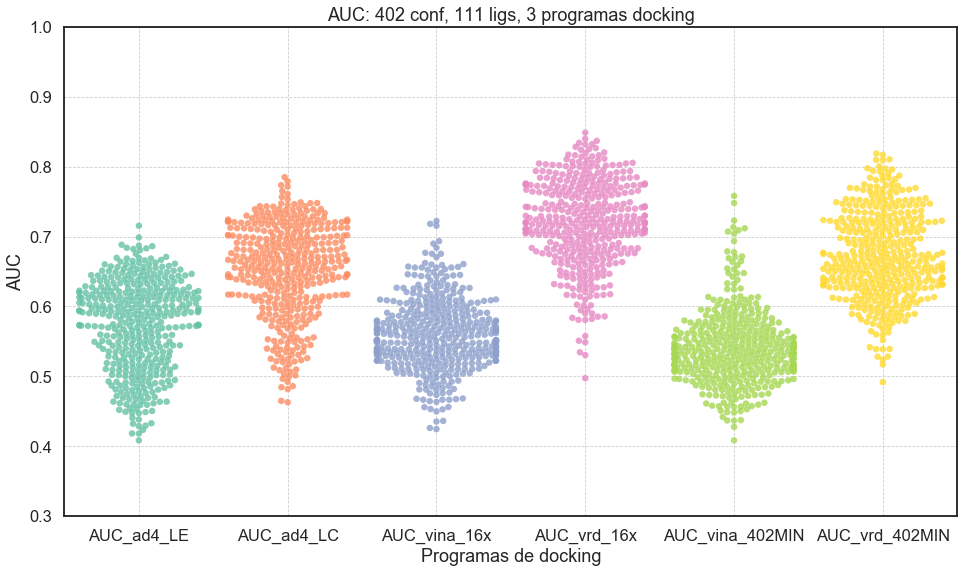

In [25]:
fig, axes = plt.subplots()

data = df_auc_scores_CRYS_vs_MIN
data = data.melt()
data['Conf Labels'] = np.tile(df_cdk2_labels.Labels_conf, 6)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
               palette=  'Set2', s = 6.5)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

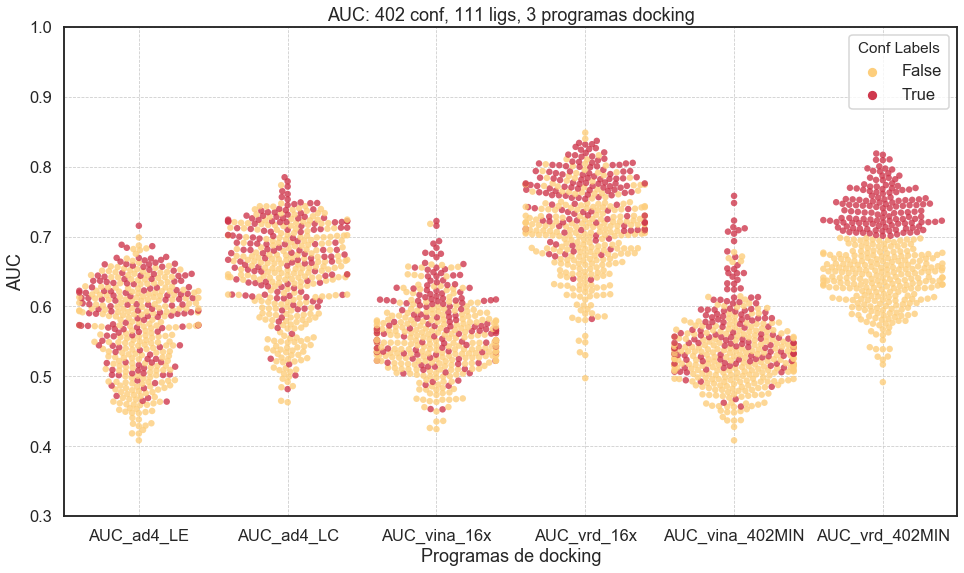

In [33]:
fig, axes = plt.subplots()

cmp = sns.set_palette(['#fdce7c', '#cf384d', 'green', '#93d067',  '#3498db'])
data = df_auc_scores_CRYS_vs_MIN
data = data.melt()
data['Conf Labels'] = np.tile(df_cdk2_labels.AUC_vrd_402MIN > 0.7, 6)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = "Conf Labels", palette= cmp, s = 6.5)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

### Mejores conformaciones de Vinardo (AUC de >0.8)

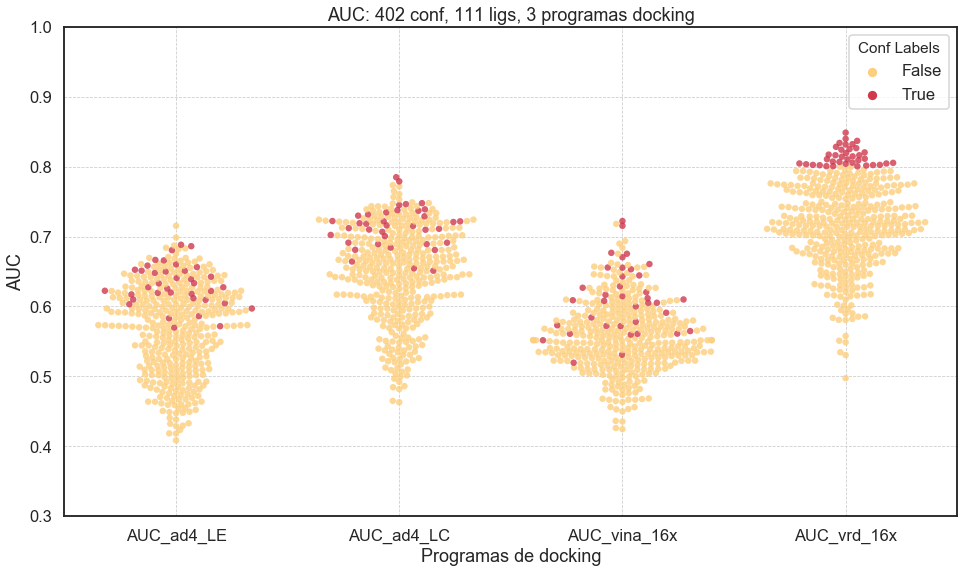

In [33]:
fig, axes = plt.subplots()

cmp = sns.set_palette(['#fdce7c', '#cf384d', 'green', '#93d067',  '#3498db'])
data = df_auc_scores
data = data.melt()
data['Conf Labels'] = np.tile(df_cdk2_labels.AUC_vrd_16x > 0.8, 4)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = "Conf Labels", palette= cmp, s = 6.5)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

### Etiquetado de las conforamciones según su estado Activo/Inactivo

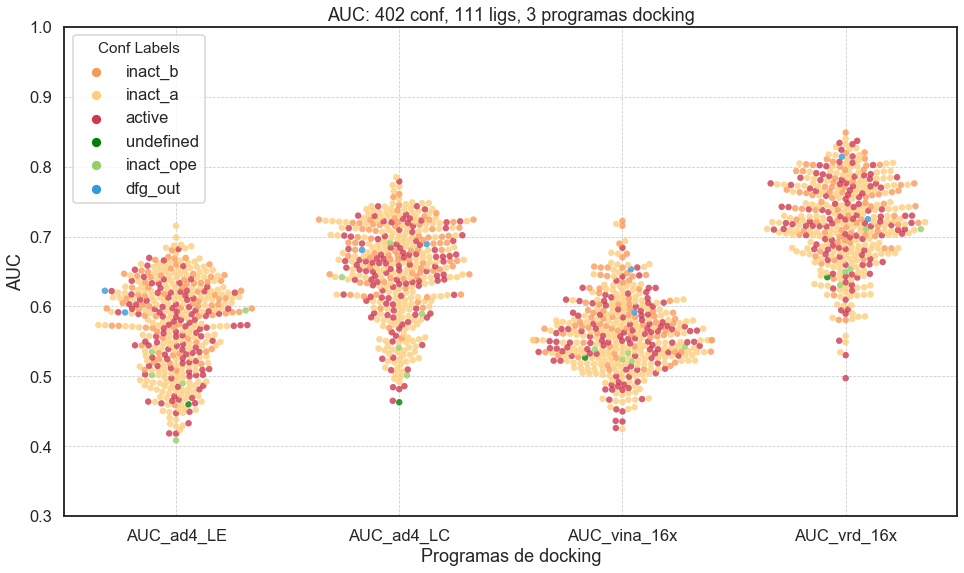

In [34]:
fig, axes = plt.subplots()

cmp = sns.set_palette(['#fa9a58', '#fdce7c', '#cf384d', 'green', '#93d067',  '#3498db'])
data = df_auc_scores
data = data.melt()
data['Conf Labels'] = np.tile(df_cdk2_labels.Labels_conf, 4)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = "Conf Labels", palette= cmp, s = 6.5)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

## Comparación por otras propidades de las conformaciones
### Conformaciones según la resolución del cristal

In [35]:
df_cdk2_labels.Resolution.describe()

count    402.000000
mean       2.023657
std        0.408628
min        0.980000
25%        1.800000
50%        1.990000
75%        2.247500
max        3.500000
Name: Resolution, dtype: float64

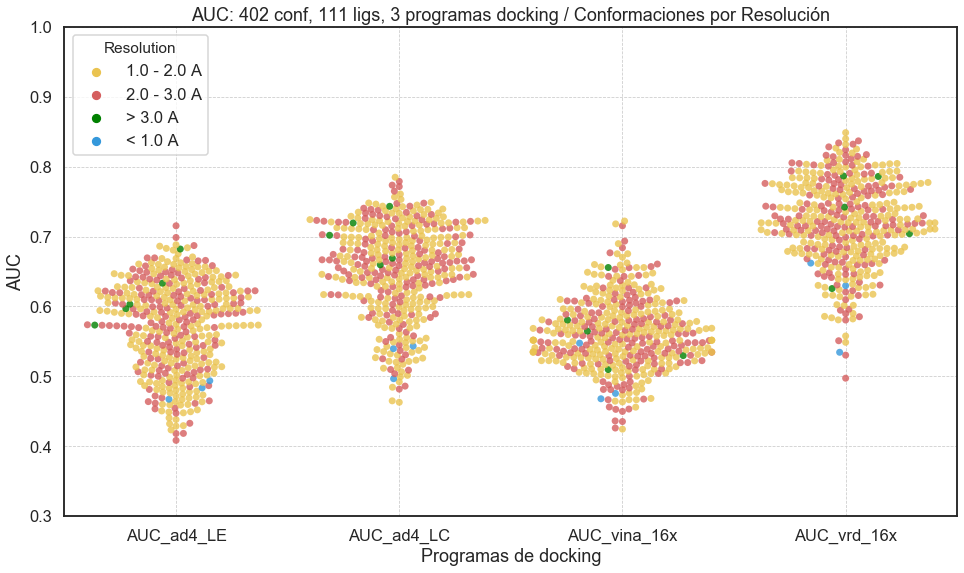

In [36]:
# Por  resoluciones de las conformaciones
resolution = ["< 1.0 A" if i <= 1.0
              else "1.0 - 2.0 A" if i <= 2
              else "2.0 - 3.0 A" if i <= 3
              else "> 3.0 A"
              for i in df_cdk2_labels.Resolution]

fig, axes = plt.subplots()

cmp = sns.set_palette(['#EAC350',  '#D55E5E', 'green',  '#3498db'])
data = df_auc_scores
data = data.melt()
data['Resolution'] = np.tile(resolution, 4)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = "Resolution", palette= cmp, s = 7)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking / Conformaciones por Resolución')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

### Por cobertura de secuencia en la estructura cristalográfica

In [37]:
df_cdk2_labels.Coverage.describe()

count    402.000000
mean      97.065011
std        2.788320
min       86.577181
25%       94.966443
50%       97.986577
75%       99.328859
max      102.013423
Name: Coverage, dtype: float64

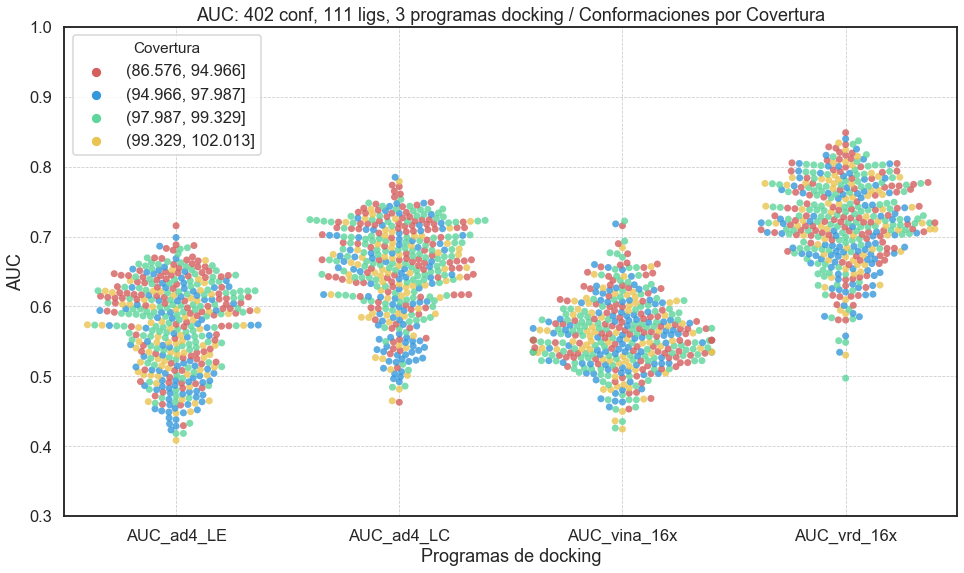

In [38]:
# por covertura de las Conformaciones
# Por  resoluciones de las conformaciones
covertura = pd.qcut(df_cdk2_labels.Coverage, 4)


fig, axes = plt.subplots()

cmp = sns.set_palette(['#D55E5E', '#3498db',  '#5ED59B', '#EAC350'])
data = df_auc_scores
data = data.melt()
data['Covertura'] = np.tile(covertura, 4)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = "Covertura", palette= cmp, s = 7)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking / Conformaciones por Covertura')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

### Por volumen de la cavidad

In [39]:
# Cargamos los valores del volumen del pocket
col_names = ['frame', 'pocket_volume']
volumen_402_stc = pd.read_csv('../ARCHIVOS/CRISTALES/VOLUMEN/CDK2_VOL_RICCI_402/res_volumes.tabbed.txt', 
                              sep = "\t", header=None, names= col_names)

In [40]:
volumen_402_stc[['pocket_volume']].describe()

,pocket_volume
count,402.000000
mean,779.631841
std,138.063446
min,405.000000
25%,684.250000
50%,760.000000
75%,843.750000
max,1534.000000


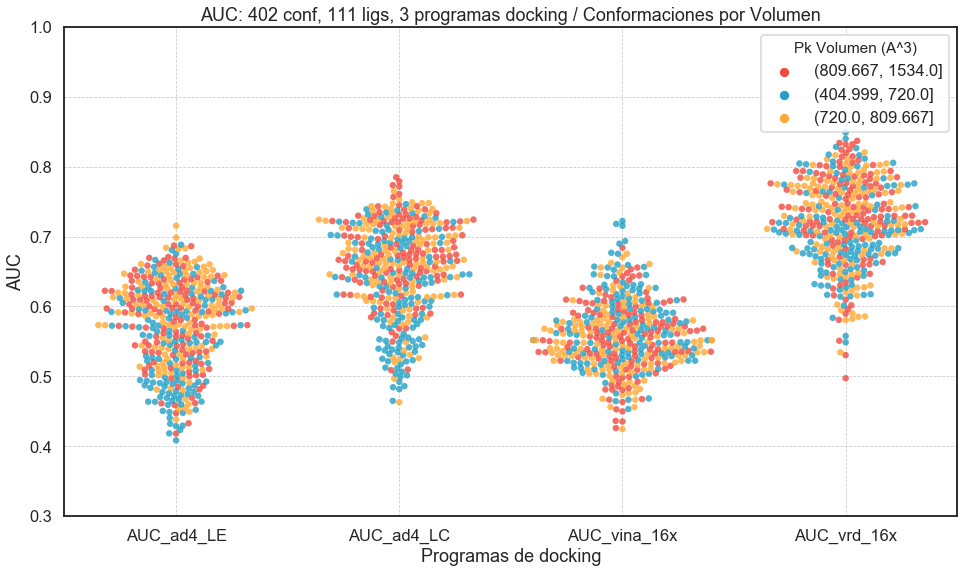

In [41]:
volumen = pd.qcut(volumen_402_stc.pocket_volume, 3)

fig, axes = plt.subplots()

cmp = sns.set_palette(['#F14B3E', '#21A0C5', '#FFA832'])
data = df_auc_scores
data = data.melt()
data['Pk Volumen (A^3)'] = np.tile(volumen, 4)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = 'Pk Volumen (A^3)', palette= cmp, s = 6.5)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking / Conformaciones por Volumen')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

### Conformaciones por cluster según su cavidad
**Propiedad medida con POVME**

In [42]:
# por cluster de pocket
cluster_members_file = '../ARCHIVOS/CRISTALES/VOLUMEN/CDK2_VOL_PISANI_402/res_frameInfo/cluster_members.csv'
with open(cluster_members_file) as f:
    lines = f.readlines()

dic_cluster_pockets = {}
for i, line in enumerate(lines):
    split_line = line.replace('\n', '').split(' ')
    dic_cluster_pockets[F'cluster_{i+1}'] = ([ int(element.split('__')[-1]) -1 for element in split_line])
    
df_cdk2_labels['pocket_cluster'] = 0
# Llenamos la columna
df_cdk2_labels.reset_index(inplace=True)
for key in dic_cluster_pockets.keys():
    for value in dic_cluster_pockets[key]:
        df_cdk2_labels.at[value, 'pocket_cluster'] = int(key.split('_')[-1])

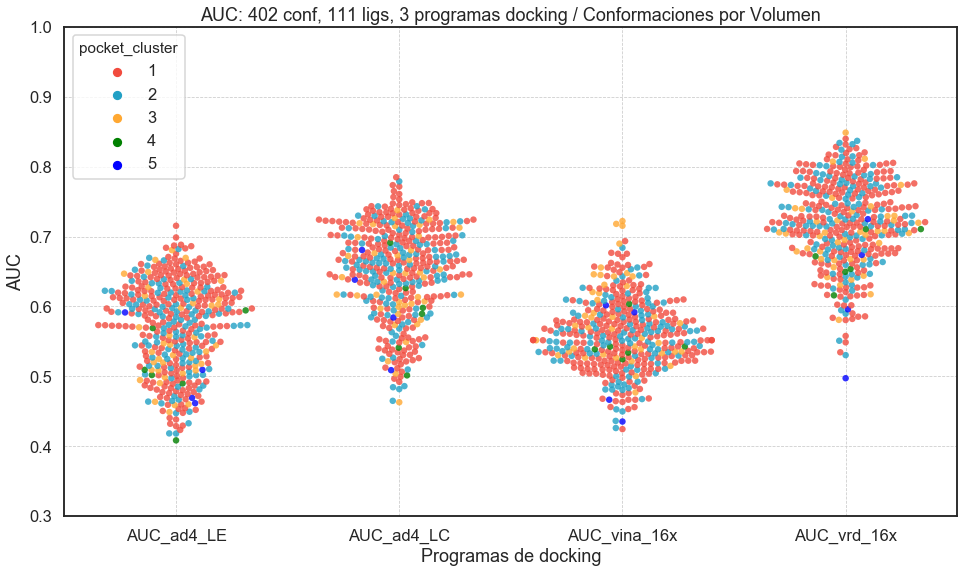

In [43]:
fig, axes = plt.subplots()

cmp = sns.set_palette(['#F14B3E', '#21A0C5', '#FFA832', 'green', 'blue'])
data = df_auc_scores
data = data.melt()
data['pocket_cluster'] = np.tile(df_cdk2_labels['pocket_cluster'], 4)

fig.set_size_inches(16, 9)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = 'pocket_cluster', palette= cmp, s = 6.5)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking / Conformaciones por Volumen')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

### Conformaciones por masa del ligando
**Conformaciones según la masa del ligando acoplado en el sitio activo, conforamciones sin ligando la masa = 0.**

In [44]:
df_cdk2_labels.Inhib_mass.replace("", 0, inplace=True)
pd.to_numeric(df_cdk2_labels.Inhib_mass).describe()

count    402.000000
mean     285.216418
std      115.075581
min        0.000000
25%      238.000000
50%      306.000000
75%      366.000000
max      462.000000
Name: Inhib_mass, dtype: float64

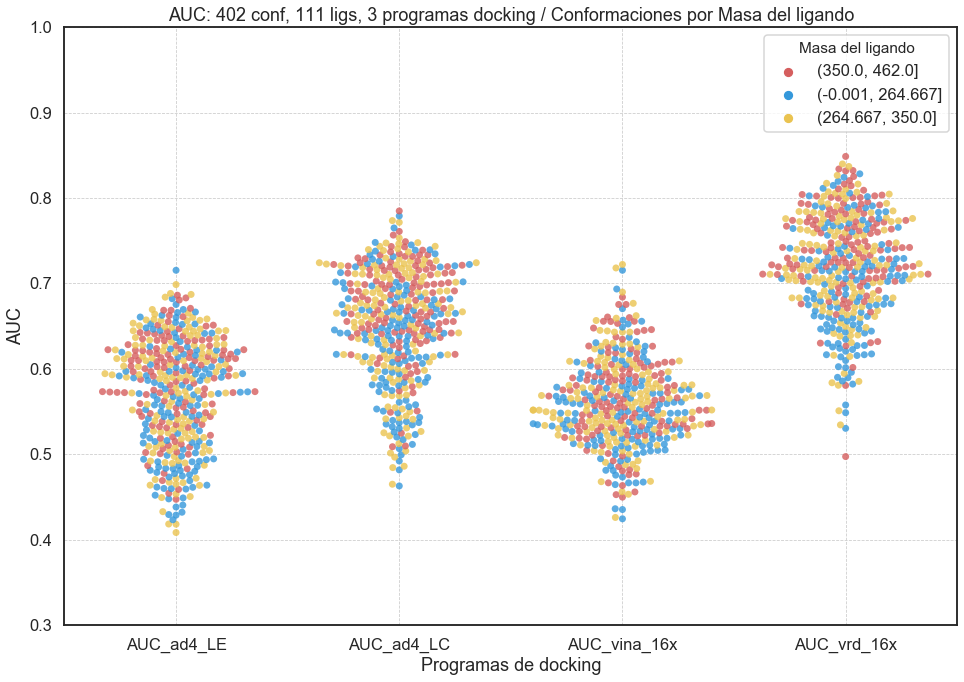

In [45]:
masa_ligando = pd.qcut(pd.to_numeric(df_cdk2_labels.Inhib_mass), 3)

fig, axes = plt.subplots()

cmp = sns.set_palette(['#D55E5E', '#3498db', '#EAC350'])
data = df_auc_scores
data = data.melt()
data['Masa del ligando'] = np.tile(masa_ligando, 4)

fig.set_size_inches(16, 11)
sns.swarmplot(x = "variable", y = "value", data= data, ax = axes, alpha=0.8, 
              hue = "Masa del ligando", palette= cmp, s = 7)
axes.set_title('AUC: 402 conf, 111 ligs, 3 programas docking / Conformaciones por Masa del ligando')
axes.grid(linestyle='--', linewidth='0.8')
plt.xlabel("Programas de docking")
plt.ylabel("AUC")
plt.ylim(0.3, 1)
plt.show()

# Análisis estadístico 
### Análisis estadístico  de la distribución de valores AUC por método de docking

In [46]:
# Evaluamos la normalidad de los datos
import pylab
import scipy.stats as stats
import statsmodels.api as sm

In [47]:
df_auc_scores.describe().T

,count,mean,std,min,25%,50%,75%,max
AUC_ad4_LE,402.0,0.571919,0.064531,0.408371,0.522002,0.583484,0.621719,0.715385
AUC_ad4_LC,402.0,0.651196,0.066604,0.462896,0.611595,0.661538,0.702149,0.784842
AUC_vina_16x,402.0,0.560658,0.051570,0.424434,0.527376,0.557240,0.591968,0.722172
AUC_vrd_16x,402.0,0.719259,0.061990,0.497285,0.680769,0.720814,0.768269,0.848643


## Normalidad de los datos

La prueba de hipótesis para cada muestra $i$ es la siguiente:

> $H_0$: *La muestra $i$ sigue una distribución normal.* 

> $H_a$: *La muestra $i$ __NO__ sigue una distribución normal.* 

#### *Test* de Shapiro-Wilks con datos crudos

In [48]:
# Normalidad de los datos
for test in df_auc_scores.columns:
    norm_t = stats.shapiro(df_auc_scores[test])
    print(F'{test}:\t W = {round(norm_t[0], 3)}  p = {round(norm_t[1], 5)}')

AUC_ad4_LE:	 W = 0.973  p = 0.0
AUC_ad4_LC:	 W = 0.965  p = 0.0
AUC_vina_16x:	 W = 0.993  p = 0.04831
AUC_vrd_16x:	 W = 0.982  p = 6e-05


#### *Test* de Shapiro-Wilks con datos estandarizados

In [49]:
from sklearn.preprocessing import StandardScaler
# Datos estandarizados (z-score)
df_std_auc_values = pd.DataFrame(StandardScaler().fit_transform(df_auc_scores), 
                                 columns= df_auc_scores.columns)

In [50]:
# Normalidad de los datos estandarizados
for test in df_std_auc_values.columns:
    norm_t = stats.shapiro( df_std_auc_values[test])
    print(F'stdrzd {test}:\t W = {round(norm_t[0], 3)}  p = {round(norm_t[1], 5)}')

stdrzd AUC_ad4_LE:	 W = 0.973  p = 0.0
stdrzd AUC_ad4_LC:	 W = 0.965  p = 0.0
stdrzd AUC_vina_16x:	 W = 0.993  p = 0.04832
stdrzd AUC_vrd_16x:	 W = 0.982  p = 6e-05


#### *Test* de Shapiro-Wilks con transformación logarítmica

In [51]:
# Transformación de los datos, logaritmo base 10
df_log_auc_values = np.log10(df_auc_scores)
for test in df_log_auc_values.columns:
    norm_t = stats.shapiro( df_log_auc_values[test])
    print(F'log_{test}:\t W = {round(norm_t[0], 3)}  p = {round(norm_t[1], 5)}')

log_AUC_ad4_LE:	 W = 0.959  p = 0.0
log_AUC_ad4_LC:	 W = 0.945  p = 0.0
log_AUC_vina_16x:	 W = 0.996  p = 0.43003
log_AUC_vrd_16x:	 W = 0.965  p = 0.0


**En cualquiera de los tres caso casos, para todas las muestras, se obtiene `p-value < 0.05`, con lo cual se rechaza la hipótesis nula y se concluye, con un nivel de significancia del 95\%, que ninguana de las muestras sigue una distribución normal.**

###  Q-Q plots
Sólo para visualizar la distribución de los datos.

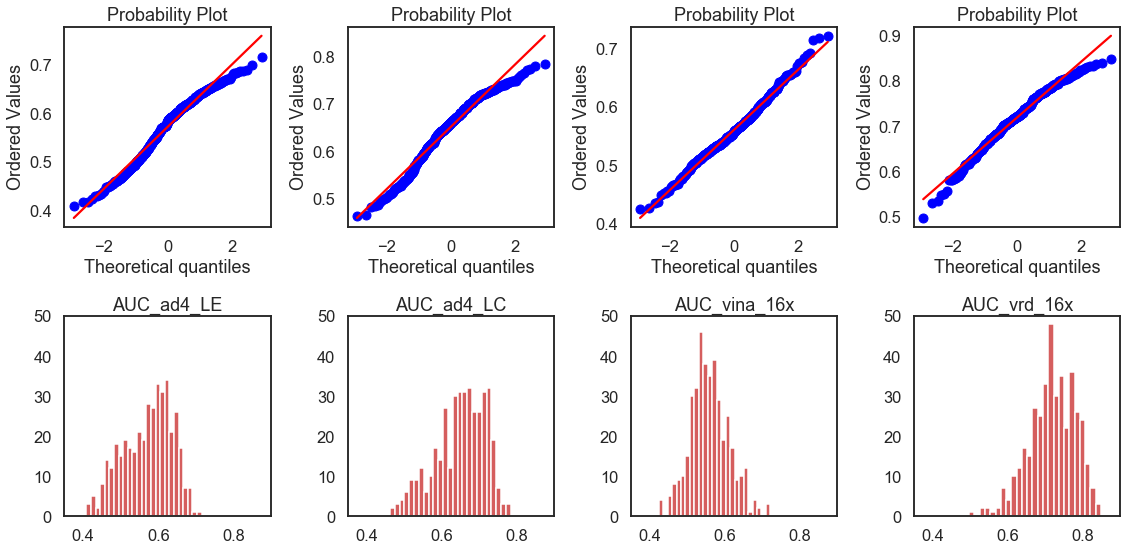

In [52]:
fig, axes = plt.subplots()
fig.set_size_inches(16, 8)

for i, auc_results in enumerate(df_auc_scores.columns):
    plt.subplot(2, 4, i + 1)
    stats.probplot(df_auc_scores[auc_results], dist = "norm", plot=pylab)
    plt.subplot(2, 4, i + 5)
    plt.hist(df_auc_scores[auc_results], bins= 25)
    plt.xlim((0.35, 0.9))
    plt.ylim((0, 50))
    plt.title(auc_results)
fig.tight_layout()  
plt.show()

# Evaluación de la Homocedasticidad
La prueba de hipótesis es la siguiente:
> $H_0$: *Todas las muestras son homocedasticas.* $\Longrightarrow \sigma_0 = \sigma_1 ... = \sigma_k$

> $H_0$: *Al menos un par de muestras tienen varianzas distintas.* $\Longrightarrow \sigma_i \neq \sigma_j$ 

### *Test de Levenne* para muestras no normales
#### Datos crudos

In [53]:
# Test de levene para evaluar homocedasticidad en muestras no normales
stats.levene(*df_auc_scores.T.values,  center="median")

LeveneResult(statistic=11.01377348278758, pvalue=3.6973467468158526e-07)

> **Conclusión:** Cuando los **datos crudos** son evaluados, se rechaza la hipótesis nula y se cncluye que las muestras no son homocedásticas.

#### Datos estandarizados por columna (método de *docking*)

In [54]:
stats.levene(*df_std_auc_values.T.values,  center="median")

LeveneResult(statistic=0.4491018357286637, pvalue=0.717966164490951)

> **Conclusión:** Cuando los **datos estandarizados por método** son evaluados, se rechaza la hipótesis nula y se cncluye que las muestras no son homocedásticas.

### Visualización de la distribución de los datos

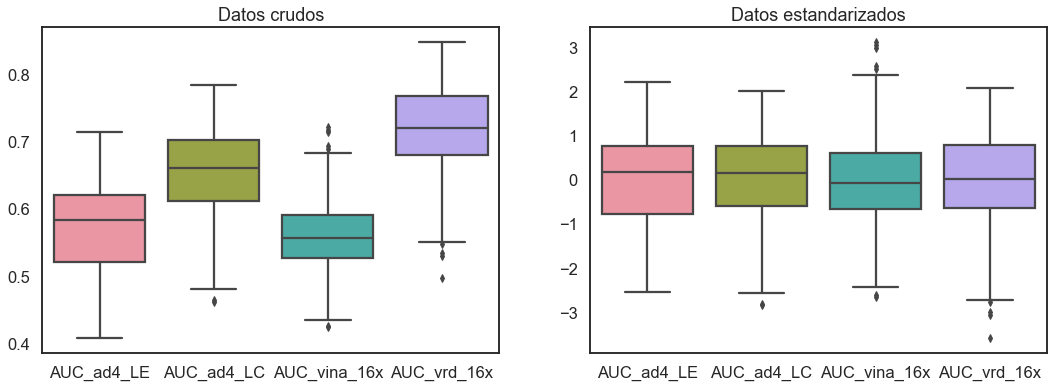

In [55]:
fig, axes = plt.subplots()
fig.set_size_inches(18, 6)

plt.subplot(1, 2, 1)
sns.boxplot(data = df_auc_scores)
plt.title("Datos crudos")
plt.subplot(1, 2, 2)
sns.boxplot(data = df_std_auc_values)
plt.title("Datos estandarizados")
plt.show()

> ### NOTA: 
A mi entender, deberíamos evaluar las muestras con los datos no estandarizados y que la escala de todos los datos es la misma: valores AUC.

# Comparación de las muestras
## Prueba de Kruskal-Wallis

La prueba de Kruskal-Wallis (KW) es la alternativa no paramétrica a la prueba ANOVA de una vía. KW es un test que emplea rangos para contrastar la hipótesis de que tres o más muestras hayan sido obtenidas de la misma población. 

Supuestos de Kruskal-Wallis:
1. **Aleatoreidad de las muestras.**
2. **Independencia de las muestras.**
3. **Homogeneidad de varianzas (sólo si se busca inferir sobre las medianas de los grupos):**
> #### Este supuesto puede omitirse si la inferencia se hace sobre *dominancia estocástica*:  
1. *Some authors state unambiguously that there are no distributional assumptions, others that the homogeneity of variances assumption applies just as for parametric ANOVA. The confusion results from how you interpret a significant result.  If you wish to compare medians or means, then the Kruskal-Wallis test also assumes that observations in each group are identically and independently distributed apart from location. If you can accept inference in terms of dominance of one distribution over another, then there are indeed no distributional assumptions.*  
*The commonest misuse of Kruskal-Wallis is to accept a significant result as indicating a difference between means or medians, even when distributions are wildly different. Such results should only be interpreted in terms of dominance. When distributions are similar, medians should be reported rather than means since they (in the form of mean ranks) are what the test is actually comparing. In fact, box and whisker plots with median, interquartile range, outliers and extremes should be the minimum requirement for reporting results of a Kruskal-Wallis test.*  
**[Referencia 1](https://influentialpoints.com/Training/Kruskal-Wallis_ANOVA_use_and_misuse.htm)**.
2. *Heterogeneous variances will make interpretation of the result more complex*  
**[Referencia 2](https://influentialpoints.com/Training/kruskal-wallis_anova.htm)**.
3. *If the distributions differ in shape and/or variance, a significant KW test implies there is at least one group that is stochastically greater (lesser) than the others, but its mean (and median, and first quartile, and eighty-eighth percentile, etc.) is not necessarily higher (lower) than the other groups.*  
**[Referencia 3](https://stats.stackexchange.com/questions/278001/kruskal-wallis-test-assumption-testing-and-interpretation-of-the-results)**.

### Prueba de hipótesis
Prueba de hipótesis (interpretada en términos de dominancia y no de las medianas de las muestras. Esto significa que la hipótesis alternativa es que existe una probabilidad significativa de que al obtener un individuo de al menos una muestra $i$ su valor más grande que la de algún individuo de otra muestr $j$:

> **$H_0$: Todas las muestras provienen de la misma población.**  
    $H_0$: Para cada par de muestras $ij \rightarrow P(X_i > X_j = 0.5)$

> **$H_a$: Al menos una muestra proviene de una población con una distribución distinta.**  
$H_0$: Para al menos un par de muestras $ij \rightarrow P(X_i > X_j \neq 0.5)$

### Ejecución de la prueba ([Fuente](https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/))

Realizamos el test de Kruskal-Wallis sobre los datos en crudo (sin estandarizar).

In [56]:
H, p = stats.kruskal(*df_auc_scores.T.values)
print(F'H = %.5f\np = %.5f' % (H, p))

H = 849.90758
p = 0.00000


> #### Conclusión (Usando datos sin estandarizar): 
Se rechaza la hipótesis nula y se concluye, con un *p-value* < 0.001 que al menos una de las muestras es distinta.

### Prueba post-hoc

In [57]:
import scikit_posthocs as posthoc

In [58]:
phoc_wilcoxon = posthoc.posthoc_wilcoxon(df_auc_scores.T.values)
phoc_wilcoxon.columns = df_auc_scores.columns
phoc_wilcoxon.index = df_auc_scores.columns
phoc_wilcoxon.round(5)

,AUC_ad4_LE,AUC_ad4_LC,AUC_vina_16x,AUC_vrd_16x
AUC_ad4_LE,-1.0000,0.0,0.0004,0.0
AUC_ad4_LC,0.0000,-1.0,0.0000,0.0
AUC_vina_16x,0.0004,0.0,-1.0000,0.0
AUC_vrd_16x,0.0000,0.0,0.0000,-1.0


> #### Conclusión (Usando datos sin estandarizar): 
Todos los pares de muestras $ij$ son significativamente distintos entre sí.

## Prueba de Friedman

Alternativa no paramétrica para el ANOVA de una vía con mediciones repetidas (muestras pareadas). Es usada para evaluar si tres o más muestras son distintas. Por lo tanto, al contrario de Kruskal-Wallis, esta prueba no asume independencia de las muestras. **[Fuente](https://statistics.laerd.com/spss-tutorials/friedman-test-using-spss-statistics.php)**


Supuestos del test de Friedman:
> 1. **Las muestras provienen de un mismo grupo medido en tres o más ocasiones.**
2. **Aleatoriedad de las muestras. Cada muestra es una muestra alatoria de la población.**
3. **Los valores son continuos o al menos ordinales.**
4. **Las muestras NO necesitan seguir una distribución normal.**

Prueba de hipótesis:

> **$H_0$: Todas las muestras provienen de la misma población.**  
    $H_0$: Para cada par de muestras $ij \rightarrow P(X_i > X_j = 0.5)$

> **$H_a$: Al menos una muestra proviene de una población con una distribución distinta.**  
$H_0$: Para al menos un par de muestras $ij \rightarrow P(X_i > X_j \neq 0.5)$

### Ejecución de la prueba Friedman

In [59]:
f, p = stats.friedmanchisquare(*df_auc_scores.T.values)
print(F'F = %.5f\np = %.5f' % (H, p))

F = 849.90758
p = 0.00000


> #### Conclusión (Usando datos sin estandarizar): 
Se rechaza la hipótesis nula y se concluye, con un *p-value* < 0.001 que al menos una de las muestras es distinta.

### Prueba post-hoc (Friedman)

In [60]:
phoc_nemenyi = posthoc.posthoc_nemenyi_friedman(df_auc_scores.values)
phoc_nemenyi.columns = df_auc_scores.columns
phoc_nemenyi.index = df_auc_scores.columns
phoc_nemenyi.round(3)

,AUC_ad4_LE,AUC_ad4_LC,AUC_vina_16x,AUC_vrd_16x
AUC_ad4_LE,-1.000,0.001,0.748,0.001
AUC_ad4_LC,0.001,-1.000,0.001,0.001
AUC_vina_16x,0.748,0.001,-1.000,0.001
AUC_vrd_16x,0.001,0.001,0.001,-1.000


> #### Conclusión (Usando datos sin estandarizar): 
Sólo el par `AUC_vina` y `AUC_ad4_LE` son similares, el resto de los pares de muestras son significativamente distintos.

# ¡Terminado!